In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split  #to split train and test data
from sklearn.feature_selection import SelectKBest, chi2  #to select best features using SelectKBest method
from sklearn.ensemble import RandomForestClassifier   
from sklearn.metrics import accuracy_score  #to calculate accuracy

import scipy.stats as stats    #to calculate chisquare
from scipy.stats import chi2_contingency

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
#load all tables

df=pd.read_sas('extrel.sas7bdat')
df_payhistory=pd.read_sas('payhistory.sas7bdat')
df_mailinglanguage=pd.read_sas('nameaddr.sas7bdat')
df_comunication=pd.read_sas('communication.sas7bdat')
df_topiccode=pd.read_sas('commaint.sas7bdat')
df_contactclass=pd.read_sas('comclas.sas7bdat')
df_activity=pd.read_sas('extrelty.sas7bdat')

In [4]:
#prepare base table 

df=pd.merge(df, df_payhistory, on='EXTRELNO', how='left')   #join pay history table to base table

#calculate total amount paid by each customer
totalamtpaid=df.groupby('EXTRELNO', as_index=False)['PAMT'].sum()   
totalamtpaid = totalamtpaid.rename(columns={'PAMT':'Total_AmountPaid'})

#calculate avg amount paid by each customer
avgamtpaid=df.groupby('EXTRELNO', as_index=False)['PAMT'].mean()
avgamtpaid = avgamtpaid.rename(columns={'PAMT':'Average_AmountPaid'})

#merge total and avg amount to base table
df=pd.merge(df, totalamtpaid, on='EXTRELNO', how='left')
df=pd.merge(df, avgamtpaid, on='EXTRELNO', how='left')

#add mailing language
df_mailinglanguage=df_mailinglanguage.drop(columns=['NAME1TITLE', 'POSTCODE'])
df=pd.merge(df, df_mailinglanguage, on='EXTRELNO', how='left')


#merge contact class with communication

df_comunication=pd.merge(df_comunication, df_contactclass, on='CLASCODE', how='left')
df_comunication=df_comunication.drop(columns=['CONTID', 'MEDIUMCODE', 'MNTOPCODE', 'CLASCODE', 'CONTDATE']) #drop unnecessary columns
df_comunication=df_comunication.sort_values('EXTRELNO')  #sort records
df_comunication=df_comunication.drop_duplicates(subset='EXTRELNO')   #remove duplicates
df=pd.merge(df, df_comunication, on='EXTRELNO', how='left')   #merge with main data frame


In [5]:
df.head()

,EXTRELNO,EXRELACTCD,EXTRELSTDT,EXRELDATEN,PID,PDATE,PAMT,PAYTYPECD,STATUS,Total_AmountPaid,Average_AmountPaid,LANGUACODE,CONTDIREC,CLASDESC
0,b'0026414',b'CT',1995-02-02,NaT,40099.0,1993-12-31,10.58,b'X',b'CO',3112.8,19.953846,b'NL',b'O',b'Information delivery'
1,b'0026414',b'CT',1995-02-02,NaT,77670.0,1994-01-01,2.02,b'X',b'CO',3112.8,19.953846,b'NL',b'O',b'Information delivery'
2,b'0026414',b'CT',1995-02-02,NaT,115809.0,1994-05-19,0.50,b'D',b'OK',3112.8,19.953846,b'NL',b'O',b'Information delivery'
3,b'0026414',b'CT',1995-02-02,NaT,139954.0,1994-06-14,0.50,b'D',b'OK',3112.8,19.953846,b'NL',b'O',b'Information delivery'
4,b'0026414',b'CT',1995-02-02,NaT,162748.0,1994-07-05,0.50,b'D',b'OK',3112.8,19.953846,b'NL',b'O',b'Information delivery'


In [6]:
df.shape

(1291813, 14)

In [7]:
#if complaint was ever made=1
df['CONTDIREC'] = np.where(df['CONTDIREC'] == 'I', 1, 0)

#if communication was ever incoming
df['CLASDESC'] = np.where(df['CLASDESC'] == 'Complaint', 1, 0)


#create dependent variable
df['Churn'] = np.where(df['EXRELDATEN'].isnull(), 0, 1)


#create new variable to indicate whether user has used pay type
df['PAYTYPECD'] = np.where(df['PAYTYPECD'].isnull(), 0, 1)

In [8]:
#drop pay date
df=df.drop(columns=['PID', 'PDATE', 'PAMT', 'STATUS'])

In [9]:
#create final df with one record per customer
df_new=df.drop_duplicates(subset='EXTRELNO')

In [10]:
#create a new variable frequence in main table df
#use payhistory table to create Frequency column

df_payhistory=df_payhistory.sort_values('EXTRELNO')  
#create new Column Frequence in Pay history table
df_payhistory['Frequency'] = np.where(df_payhistory['EXTRELNO'] == df_payhistory['EXTRELNO'].shift(), abs(df_payhistory['PDATE'].shift() - df_payhistory['PDATE']), np.nan)
#convert it into number of days
df_payhistory['Frequency'] = df_payhistory['Frequency']/pd.offsets.Day(1)
#calculate mean frequesncy per customer
df_frequence = df_payhistory.groupby('EXTRELNO', as_index=False)['Frequency'].mean()
#merge it with main base table df_new
df_new = pd.merge(df_new, df_frequence, on = 'EXTRELNO', how = 'left')

In [11]:
#remove end date 
df_new = df_new.drop(columns=['EXRELDATEN'])

In [12]:
#replace missing avg amt with 0
df_new['Average_AmountPaid'] = df_new['Average_AmountPaid'].fillna(0)


#replace missing frequency with 0
df_new['Frequency'] = df_new['Frequency'].fillna(0)

In [13]:
#remove date column
df_new=df_new.drop(columns='EXTRELSTDT')

In [14]:
#create dummy variables and give the name of df as df_final
variables = ['EXRELACTCD', 'LANGUACODE']
df_final = pd.get_dummies(df_new, columns=variables)

In [15]:
#remove Id column
df_final = df_final.drop(columns='EXTRELNO')

In [16]:
#replace negative values in total amt and avg amt with 0
df_final['Average_AmountPaid'] = np.where(df_new['Average_AmountPaid'] < 0, 0, df_new['Average_AmountPaid'])
df_final['Total_AmountPaid'] = np.where(df_new['Total_AmountPaid'] < 0, 0, df_new['Total_AmountPaid'])

In [17]:
df_final.head()

,PAYTYPECD,Total_AmountPaid,Average_AmountPaid,CONTDIREC,CLASDESC,Churn,Frequency,EXRELACTCD_b'AP',EXRELACTCD_b'CT',EXRELACTCD_b'FP',EXRELACTCD_b'GR',EXRELACTCD_b'MR',EXRELACTCD_b'OI',EXRELACTCD_b'OR',EXRELACTCD_b'PF',EXRELACTCD_b'PO',EXRELACTCD_b'PP',EXRELACTCD_b'PS',EXRELACTCD_b'PT',EXRELACTCD_b'PV',EXRELACTCD_b'RV',EXRELACTCD_b'SP',EXRELACTCD_b'TR',LANGUACODE_b'EN',LANGUACODE_b'FR',LANGUACODE_b'NL'
0,1,3112.80,19.953846,0,0,0,264.967742,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,3155.05,45.725362,0,0,0,322.250000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1,524.85,14.995714,0,0,1,113.088235,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1,5572.26,19.083082,0,0,1,181.841379,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1,6101.22,145.267143,0,0,0,636.100000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [38]:
df_final.columns

Index(['PAYTYPECD', 'Total_AmountPaid', 'Average_AmountPaid', 'CONTDIREC', 'CLASDESC', 'Churn', 'Frequency', 'EXRELACTCD_b'AP'', 'EXRELACTCD_b'CT'', 'EXRELACTCD_b'FP'', 'EXRELACTCD_b'GR'', 'EXRELACTCD_b'MR'', 'EXRELACTCD_b'OI'', 'EXRELACTCD_b'OR'', 'EXRELACTCD_b'PF'', 'EXRELACTCD_b'PO'', 'EXRELACTCD_b'PP'', 'EXRELACTCD_b'PS'', 'EXRELACTCD_b'PT'', 'EXRELACTCD_b'PV'', 'EXRELACTCD_b'RV'', 'EXRELACTCD_b'SP'', 'EXRELACTCD_b'TR'', 'LANGUACODE_b'EN'', 'LANGUACODE_b'FR'', 'LANGUACODE_b'NL''], dtype='object')

In [18]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18704 entries, 0 to 18703
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PAYTYPECD           18704 non-null  int32  
 1   Total_AmountPaid    18704 non-null  float64
 2   Average_AmountPaid  18704 non-null  float64
 3   CONTDIREC           18704 non-null  int32  
 4   CLASDESC            18704 non-null  int32  
 5   Churn               18704 non-null  int32  
 6   Frequency           18704 non-null  float64
 7   EXRELACTCD_b'AP'    18704 non-null  uint8  
 8   EXRELACTCD_b'CT'    18704 non-null  uint8  
 9   EXRELACTCD_b'FP'    18704 non-null  uint8  
 10  EXRELACTCD_b'GR'    18704 non-null  uint8  
 11  EXRELACTCD_b'MR'    18704 non-null  uint8  
 12  EXRELACTCD_b'OI'    18704 non-null  uint8  
 13  EXRELACTCD_b'OR'    18704 non-null  uint8  
 14  EXRELACTCD_b'PF'    18704 non-null  uint8  
 15  EXRELACTCD_b'PO'    18704 non-null  uint8  
 16  EXRE

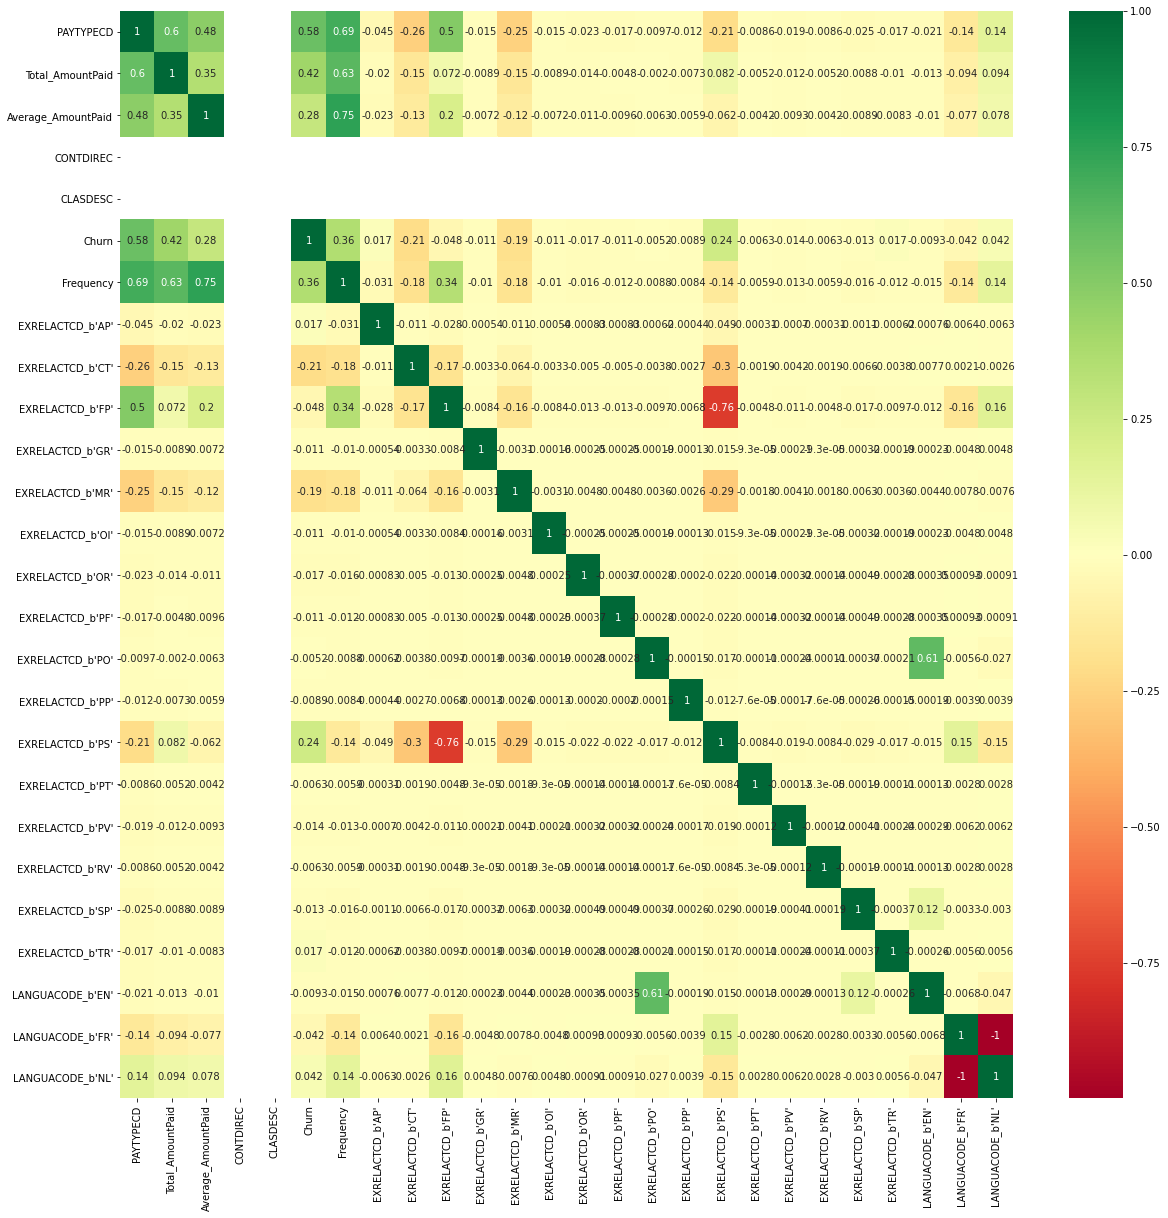

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#get correlations of each features in dataset
corrmat = df_final.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df_final[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [20]:
df_final['CLASDESC'].value_counts()

0    18704
Name: CLASDESC, dtype: int64

In [21]:
#seperating dependent and independent variables

x=df_final.drop(columns='Churn')
y=df_final['Churn']


#splitting data into train and test data
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, random_state=100)

In [22]:
### Feature Importance

from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt
model = ExtraTreesRegressor()
model.fit(x,y)

ExtraTreesRegressor()

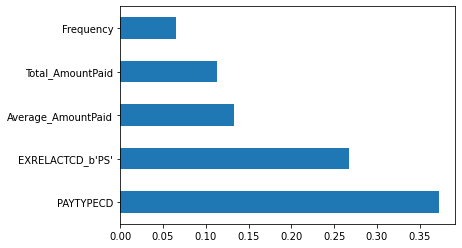

In [23]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=x.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.show()

In [24]:
#write a function to build models

def model(modelname, xtrain, ytrain, xtest, ytest):
    model = modelname.fit(xtrain, ytrain)
    predictions = model.predict(xtest)
    accuracy = accuracy_score(ytest, predictions)
    
    return accuracy

In [25]:
#biuld simple models of Logistic regression, decision tree and RM

print('Accuracy of Logistic Regression model is :', model(LogisticRegression(), xtrain, ytrain, xtest, ytest))
print('Accuracy of Decision tree model is :',model(RandomForestClassifier(), xtrain, ytrain, xtest, ytest))
print('Accuracy of Random Forest model is :',model(DecisionTreeClassifier(), xtrain, ytrain, xtest, ytest))

#Decision tress has highest Accuracy

Accuracy of Logistic Regression model is : 0.854775481111903
Accuracy of Decision tree model is : 0.9408410548823949
Accuracy of Random Forest model is : 0.9272986457590877


In [26]:
from sklearn.model_selection import RandomizedSearchCV

In [27]:
#Randomized Search CV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

In [28]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 15, 20, 25, 30], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [1, 2, 5, 10]}


In [29]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()

In [30]:

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)

In [31]:
rf_random.fit(xtrain,ytrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=  12.5s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.4s remaining:    0.0s


[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=  11.9s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=  13.8s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=  11.9s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=  10.8s
[CV] n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15 
[CV]  n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15, total=  15.1s
[CV] n_estimators=1100, min_samples_split=10, mi

[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   7.6s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   7.6s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   7.6s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   7.6s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   8.2s
[CV] n_estimators=700, min_samples_split=15, min_sam

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  8.3min finished


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [32]:
rf_random.best_params_

{'n_estimators': 300,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 15}

In [33]:
rf_random.best_score_

-0.06523069500631659

In [34]:
predictions=rf_random.predict(xtest)

In [35]:
accuracy = accuracy_score(ytest, predictions)
accuracy

0.937455452601568

<AxesSubplot:xlabel='Churn'>

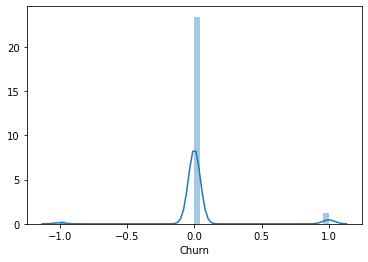

In [36]:
sns.distplot(ytest-predictions)


In [37]:
import pickle
# open a file, where you ant to store the data
file = open('random_forest_classifier_model.pkl', 'wb')

# dump information to that file
pickle.dump(rf_random, file)